In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile
from pathlib import Path

ZIP_PATH = Path("/content/drive/MyDrive/archive(9).zip")
EXTRACT_DIR = Path("dataset_extracted")

with zipfile.ZipFile(ZIP_PATH, 'r') as zf:
    zf.extractall(EXTRACT_DIR)

print("Dataset extracted to:", EXTRACT_DIR.resolve())

Dataset extracted to: /content/dataset_extracted


In [5]:
import os

# Define the path to the test directory
test_dir = 'dataset_extracted/test' # Assuming this path is correct

# Define the current and new directory names
current_name = 'Damaged_building'
new_name = 'damaged_buildings'

# Construct the full paths
current_path = os.path.join(test_dir, current_name)
new_path = os.path.join(test_dir, new_name)

print(f"Attempting to rename directory from '{current_path}' to '{new_path}'")

# Check if the current directory exists
if os.path.isdir(current_path):
    # Check if a directory with the new name already exists
    if not os.path.exists(new_path):
        try:
            os.rename(current_path, new_path)
            print(f"Successfully renamed directory from '{current_name}' to '{new_name}'.")
        except OSError as e:
            print(f"Error renaming directory: {e}")
    else:
        print(f"Error: Directory with the new name '{new_name}' already exists in '{test_dir}'.")
else:
    print(f"Error: Directory to rename '{current_name}' not found in '{test_dir}'.")

Attempting to rename directory from 'dataset_extracted/test/Damaged_building' to 'dataset_extracted/test/damaged_buildings'
Successfully renamed directory from 'Damaged_building' to 'damaged_buildings'.


In [6]:
import os

dataset_path = "dataset_extracted"
dir_contents = os.listdir(dataset_path)

print(f"Contents of '{dataset_path}':")
for item in dir_contents:
    print(item)

# Check if there are subdirectories, suggesting a multi-class dataset
subdirs = [d for d in dir_contents if os.path.isdir(os.path.join(dataset_path, d))]

if subdirs:
    print(f"\nDetected subdirectories (potential classes): {subdirs}")
    print(f"Number of potential classes: {len(subdirs)}")
else:
    print("\nNo subdirectories found. This might be a single-folder dataset or tabular data.")

Contents of 'dataset_extracted':
train
test

Detected subdirectories (potential classes): ['train', 'test']
Number of potential classes: 2


In [7]:
import os

train_dir = os.path.join(dataset_path, 'train')

if os.path.isdir(train_dir):
    print(f"\nContents of '{train_dir}':")
    train_subdirs = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]

    if train_subdirs:
        print(f"Detected subdirectories (potential classes within train): {train_subdirs}")
        print(f"Number of potential classes within train: {len(train_subdirs)}")

        # List contents of one class directory to see example files
        sample_class_dir = os.path.join(train_dir, train_subdirs[0])
        print(f"\nListing first 5 files from '{sample_class_dir}':")
        sample_files = os.listdir(sample_class_dir)[:5]
        for file_name in sample_files:
            print(file_name)
    else:
        print("No subdirectories found within 'train'. Listing first 5 files from 'train':")
        sample_files = os.listdir(train_dir)[:5]
        for file_name in sample_files:
            print(file_name)
else:
    print(f"'{train_dir}' is not a directory or does not exist.")


Contents of 'dataset_extracted/train':
Detected subdirectories (potential classes within train): ['damaged_buildings', 'Damaged_highway', 'debris', 'Non-damaged_highway', 'Non-damaged_building']
Number of potential classes within train: 5

Listing first 5 files from 'dataset_extracted/train/damaged_buildings':
2 (367).jpeg
2 (87).jpeg
2 (51).jpeg
2 (185).jpeg
2 (193).jpeg


In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Define target image dimensions and batch size
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
RANDOM_SEED = 42 # For reproducibility

# Paths to the dataset (assuming dataset_extracted is in the current directory)
train_dir = 'dataset_extracted/train'
test_dir = 'dataset_extracted/test'

# Set up data generators
# Training generator with augmentation and rescaling
train_datagen = ImageDataGenerator(
    rescale=1./255, # Normalize pixel values to [0, 1]
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2 # 20% of training data for validation
)

# Validation and Test generators with only rescaling
# Note: validation_datagen will be used for the validation subset from train_datagen, so it's not strictly needed for separate augmentation params if validation_split is used.
# However, a separate generator for the test set is necessary.
validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2 # This is used for the validation subset of the train_datagen
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Use flow_from_directory for each generator
print("Setting up training data generator...")
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    seed=RANDOM_SEED
)

print("\nSetting up validation data generator...")
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    seed=RANDOM_SEED
)

print("\nSetting up test data generator...")
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False # Typically set to False for test data to maintain order
)

# Print class_indices
print("\nClass indices from training generator:")
print(train_generator.class_indices)

print(f"Number of training samples: {train_generator.samples}")
print(f"Number of validation samples: {validation_generator.samples}")
print(f"Number of test samples: {test_generator.samples}")

Setting up training data generator...
Found 3018 images belonging to 5 classes.

Setting up validation data generator...
Found 751 images belonging to 5 classes.

Setting up test data generator...
Found 600 images belonging to 5 classes.

Class indices from training generator:
{'Damaged_highway': 0, 'Non-damaged_building': 1, 'Non-damaged_highway': 2, 'damaged_buildings': 3, 'debris': 4}
Number of training samples: 3018
Number of validation samples: 751
Number of test samples: 600


In [9]:
import os

# Path to the test directory
test_dir = 'dataset_extracted/test'

print(f"Analyzing the test dataset in: {test_dir}\n")

if os.path.isdir(test_dir):
    # Get the list of class directories in the test set
    test_classes = [d for d in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, d))]

    if test_classes:
        print("Test dataset classes and image counts:")
        total_test_images = 0
        for class_name in test_classes:
            class_path = os.path.join(test_dir, class_name)
            # Count the number of files (images) in each class directory
            # Assuming all files in class directories are images
            num_images = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
            print(f"- {class_name}: {num_images} images")
            total_test_images += num_images
        print(f"\nTotal images in the test dataset: {total_test_images}")
    else:
        print(f"No subdirectories (classes) found in '{test_dir}'.")
else:
    print(f"Error: Test directory '{test_dir}' not found.")

Analyzing the test dataset in: dataset_extracted/test

Test dataset classes and image counts:
- damaged_buildings: 100 images
- Damaged_highway: 100 images
- debris: 100 images
- Non-damaged_highway: 100 images
- Non-damaged_building: 200 images

Total images in the test dataset: 600


Analyzing the training dataset in: dataset_extracted/train

Training dataset classes and image counts:
- damaged_buildings: 448 images
- Damaged_highway: 720 images
- debris: 413 images
- Non-damaged_highway: 531 images
- Non-damaged_building: 1661 images

Total images in the training dataset: 3773


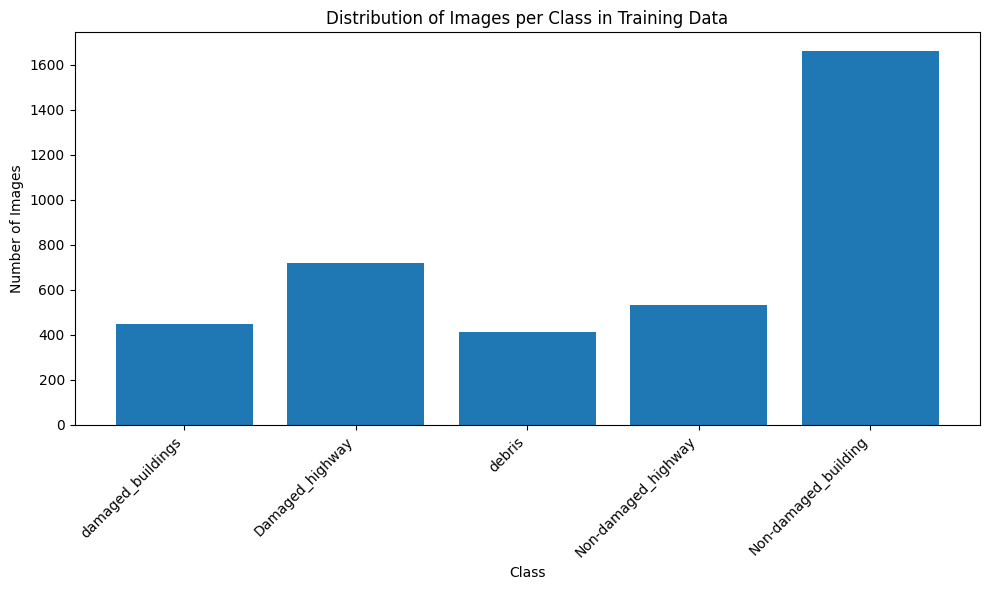

In [29]:
import os
import matplotlib.pyplot as plt

# Path to the training directory
train_dir = 'dataset_extracted/train' # Assuming this path is correct

print(f"Analyzing the training dataset in: {train_dir}\n")

if os.path.isdir(train_dir):
    # Get the list of class directories in the training set
    train_classes = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]

    if train_classes:
        print("Training dataset classes and image counts:")
        class_counts = {}
        total_train_images = 0
        for class_name in train_classes:
            class_path = os.path.join(train_dir, class_name)
            # Count the number of files (images) in each class directory
            # Assuming all files in class directories are images
            num_images = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
            class_counts[class_name] = num_images
            print(f"- {class_name}: {num_images} images")
            total_train_images += num_images

        print(f"\nTotal images in the training dataset: {total_train_images}")

        # Create a bar plot of class counts
        plt.figure(figsize=(10, 6))
        plt.bar(class_counts.keys(), class_counts.values())
        plt.title('Distribution of Images per Class in Training Data')
        plt.xlabel('Class')
        plt.ylabel('Number of Images')
        plt.xticks(rotation=45, ha='right') # Rotate labels for readability
        plt.tight_layout() # Adjust layout to prevent labels overlapping
        plt.show()

    else:
        print(f"No subdirectories (classes) found in '{train_dir}'.")
else:
    print(f"Error: Training directory '{train_dir}' not found.")

Analyzing the test dataset in: dataset_extracted/test

Test dataset classes and image counts:
- damaged_buildings: 100 images
- Damaged_highway: 100 images
- debris: 100 images
- Non-damaged_highway: 100 images
- Non-damaged_building: 200 images

Total images in the test dataset: 600


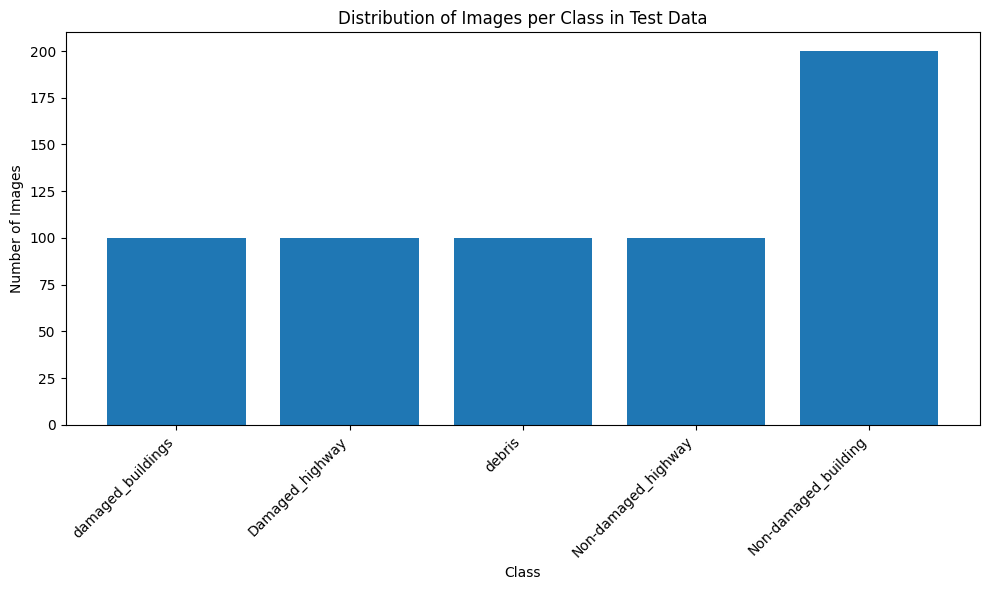

In [31]:
import os
import matplotlib.pyplot as plt

# Path to the test directory
test_dir = 'dataset_extracted/test' # Assuming this path is correct

print(f"Analyzing the test dataset in: {test_dir}\n")

if os.path.isdir(test_dir):
    # Get the list of class directories in the test set
    test_classes = [d for d in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, d))]

    if test_classes:
        print("Test dataset classes and image counts:")
        class_counts = {}
        total_test_images = 0
        for class_name in test_classes:
            class_path = os.path.join(test_dir, class_name)
            # Count the number of files (images) in each class directory
            # Assuming all files in class directories are images
            num_images = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
            class_counts[class_name] = num_images
            print(f"- {class_name}: {num_images} images")
            total_test_images += num_images

        print(f"\nTotal images in the test dataset: {total_test_images}")

        # Create a bar plot of class counts
        plt.figure(figsize=(10, 6))
        plt.bar(class_counts.keys(), class_counts.values())
        plt.title('Distribution of Images per Class in Test Data')
        plt.xlabel('Class')
        plt.ylabel('Number of Images')
        plt.xticks(rotation=45, ha='right') # Rotate labels for readability
        plt.tight_layout() # Adjust layout to prevent labels overlapping
        plt.show()

    else:
        print(f"No subdirectories (classes) found in '{test_dir}'.")
else:
    print(f"Error: Test directory '{test_dir}' not found.")

Loading sample images from: dataset_extracted/train/damaged_buildings


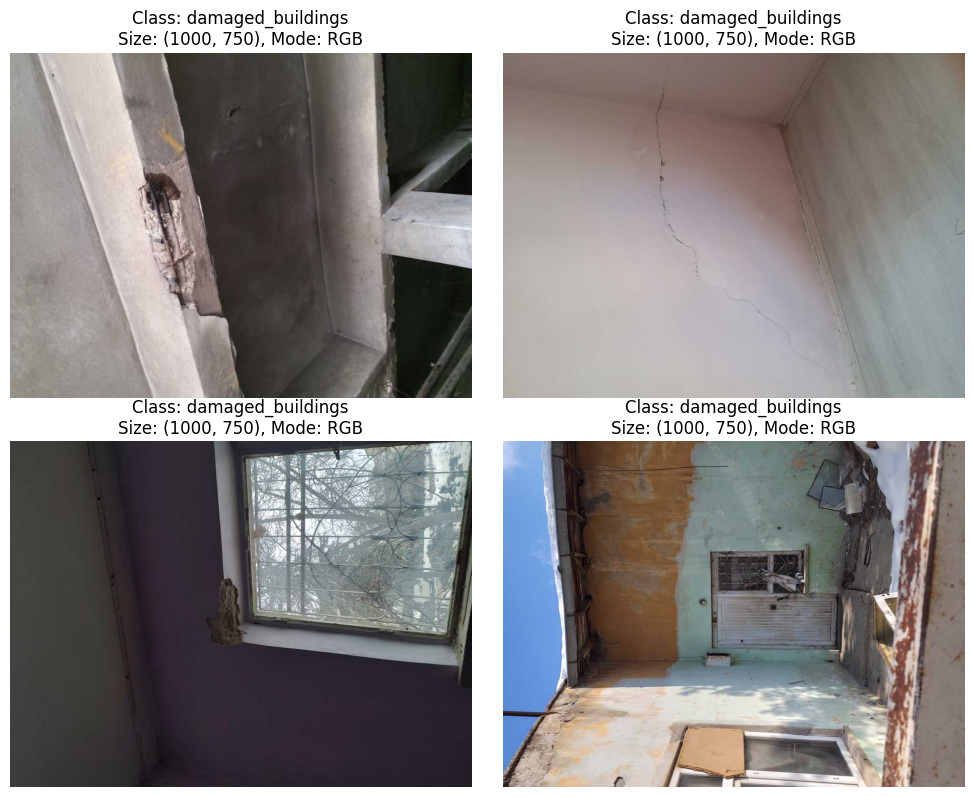

Displayed 4 sample images from 'damaged_buildings'.


In [10]:
import matplotlib.pyplot as plt
from PIL import Image
import os

# Re-using previously identified variables
# train_dir = 'dataset_extracted/train'
# train_subdirs = ['damaged_buildings', 'Non-damaged_highway', 'Damaged_highway', 'debris', 'Non-damaged_building']
# sample_class_dir = 'dataset_extracted/train/damaged_buildings'

# Get the first class directory for sampling
if train_subdirs:
    sample_class_name = train_subdirs[0]
    sample_class_path = os.path.join(train_dir, sample_class_name)
    print(f"Loading sample images from: {sample_class_path}")

    # List image files in the sample class directory
    image_files = [f for f in os.listdir(sample_class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    if image_files:
        plt.figure(figsize=(10, 8))
        for i, img_name in enumerate(image_files[:4]): # Display up to 4 sample images
            img_path = os.path.join(sample_class_path, img_name)
            try:
                img = Image.open(img_path)
                plt.subplot(2, 2, i + 1)
                plt.imshow(img)
                plt.title(f"Class: {sample_class_name}\nSize: {img.size}, Mode: {img.mode}")
                plt.axis('off')
            except Exception as e:
                print(f"Could not load image {img_name}: {e}")
        plt.tight_layout()
        plt.show()
        print(f"Displayed {min(4, len(image_files))} sample images from '{sample_class_name}'.")
    else:
        print(f"No image files found in '{sample_class_path}'.")
else:
    print("No subdirectories (classes) found to sample images from.")

In [11]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1. Define target image dimensions and batch size
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
RANDOM_SEED = 42 # For reproducibility

# Paths to the dataset
train_dir = 'dataset_extracted/train'
test_dir = 'dataset_extracted/test'

# 2-4. Set up data generators
# Training generator with augmentation and rescaling
train_datagen = ImageDataGenerator(
    rescale=1./255, # Normalize pixel values to [0, 1]
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2 # 20% of training data for validation
)

# Validation and Test generators with only rescaling
# Note: validation_datagen will be used for the validation subset from train_datagen, so it's not strictly needed for separate augmentation params if validation_split is used.
# However, a separate generator for the test set is necessary.
validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2 # This is used for the validation subset of the train_datagen
)

test_datagen = ImageDataGenerator(rescale=1./255)

# 5-6. Use flow_from_directory for each generator
print("\nSetting up training data generator...")
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    seed=RANDOM_SEED
)

print("\nSetting up validation data generator...")
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    seed=RANDOM_SEED
)

print("\nSetting up test data generator...")
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False # Typically set to False for test data to maintain order
)

# 7. Print class_indices
print("\nClass indices from training generator:")
print(train_generator.class_indices)

print(f"Number of training samples: {train_generator.samples}")
print(f"Number of validation samples: {validation_generator.samples}")
print(f"Number of test samples: {test_generator.samples}")


Setting up training data generator...
Found 3018 images belonging to 5 classes.

Setting up validation data generator...
Found 751 images belonging to 5 classes.

Setting up test data generator...
Found 600 images belonging to 5 classes.

Class indices from training generator:
{'Damaged_highway': 0, 'Non-damaged_building': 1, 'Non-damaged_highway': 2, 'damaged_buildings': 3, 'debris': 4}
Number of training samples: 3018
Number of validation samples: 751
Number of test samples: 600


In [12]:
# Print the class indices from the training generator to show the label assignments
# Assuming train_generator is available from a previous cell (e.g., 12d19200)

if 'train_generator' in globals() and hasattr(train_generator, 'class_indices'):
    print("Class indices (label assignments) from the training generator:")
    print(train_generator.class_indices)
else:
    print("Error: train_generator or its class_indices not found. Please ensure the data generators are set up correctly.")

Class indices (label assignments) from the training generator:
{'Damaged_highway': 0, 'Non-damaged_building': 1, 'Non-damaged_highway': 2, 'damaged_buildings': 3, 'debris': 4}


In [13]:
# Print the class indices from the test generator to show the label assignments
# Assuming test_generator is available from a previous cell (e.g., 12d19200 or tNLZ9EvhDuoN)

print("Displaying current class indices from the test generator:")
if 'test_generator' in globals() and hasattr(test_generator, 'class_indices'):
    print("Class indices (label assignments) from the test generator:")
    print(test_generator.class_indices)
else:
    print("Error: test_generator or its class_indices not found. Please ensure the data generators are set up correctly.")

Displaying current class indices from the test generator:
Class indices (label assignments) from the test generator:
{'Damaged_highway': 0, 'Non-damaged_building': 1, 'Non-damaged_highway': 2, 'damaged_buildings': 3, 'debris': 4}


**Reasoning**:
Following the instructions, I will define and build a deep learning model. This involves importing necessary layers and a pre-trained base model, setting up the input shape, constructing a custom classification head, combining them into a full model, and then compiling the model with appropriate optimizer, loss function, and metrics. Finally, I'll print the model summary to verify the architecture.



In [14]:
import tensorflow as tf
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2

# 1. & 2. Define input shape
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)

# Get the number of classes from the generator
num_classes = train_generator.num_classes
print(f"Number of classes detected: {num_classes}")

# 3. Load a pre-trained convolutional base model (MobileNetV2)
base_model = MobileNetV2(input_shape=INPUT_SHAPE,
                         include_top=False, # Don't include the top classification layer
                         weights='imagenet') # Load weights pre-trained on ImageNet

# Set base model layers to be non-trainable initially (feature extraction)
base_model.trainable = False
print("Base model (MobileNetV2) loaded and set to non-trainable.")

# 4. Add a custom classification head on top of the base model
# Define the input layer matching the base model's input
inputs = Input(shape=INPUT_SHAPE)

# Connect input to the base model - Removed training=False
x = base_model(inputs)

# Add the custom classification head
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='softmax')(x)

# 5. Create the full model
model = Model(inputs=inputs, outputs=outputs)
print("Custom classification head added and full model created.")

# 6. Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
print("Model compiled with Adam optimizer, categorical_crossentropy loss, and accuracy metric.")

# 7. Print a summary of the model architecture
print("\nModel Summary:")
model.summary()

Number of classes detected: 5
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Base model (MobileNetV2) loaded and set to non-trainable.
Custom classification head added and full model created.
Model compiled with Adam optimizer, categorical_crossentropy loss, and accuracy metric.

Model Summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,597 (9.24 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define training parameters
EPOCHS = 20 # You can adjust this based on observation

# Setup callbacks
# 1. ModelCheckpoint: Saves the best model based on validation accuracy
checkpoint_filepath = 'best_model.keras'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# 2. EarlyStopping: Stops training if validation accuracy doesn't improve for a certain number of epochs
# Removing EarlyStopping to train for the full number of epochs
# early_stopping_callback = EarlyStopping(
#     monitor='val_accuracy',
#     patience=5, # Number of epochs with no improvement after which training will be stopped
#     mode='max',
#     restore_best_weights=True,
#     verbose=1
# )

# Update the callbacks list to exclude EarlyStopping
callbacks = [model_checkpoint_callback] # Removed early_stopping_callback

# Train the model
print("\nStarting model training...")
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=callbacks
)

print("\nModel training finished.")


Starting model training...
Epoch 1/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - accuracy: 0.6588 - loss: 0.9592

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_accuracy improved from -inf to 0.90013, saving model to best_model.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 88s 766ms/step - accuracy: 0.6602 - loss: 0.9552 - val_accuracy: 0.9001 - val_loss: 0.2710
Epoch 2/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.8989 - loss: 0.2899
Epoch 2: val_accuracy improved from 0.90013 to 0.91079, saving model to best_model.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 48s 504ms/step - accuracy: 0.8988 - loss: 0.2900 - val_accuracy: 0.9108 - val_loss: 0.2440
Epoch 3/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.9047 - loss: 0.2543
Epoch 3: val_accuracy improved from 0.91079 to 0.92943, saving model to best_model.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 46s 483ms/step - accuracy: 0.9048 - loss: 0.2543 - val_accuracy: 0.9294 - val_loss: 0.2097
Epoch 4/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.9205 - loss: 0.2224
Epoch 4: val_accuracy did not improve from 0.92943
95/95 ━━━━━━━━━━━━━━━━━━━━ 47s 499ms/step - accuracy: 0.9205 - loss: 0.2

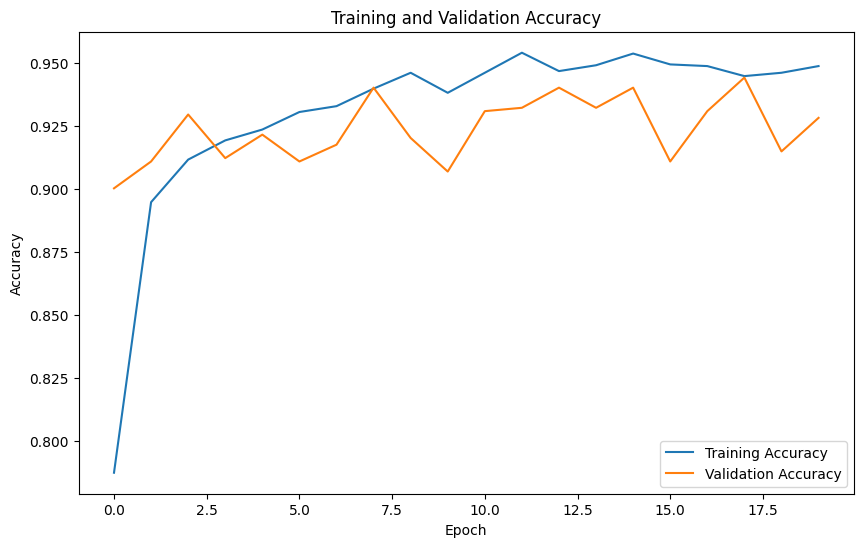

In [27]:
import matplotlib.pyplot as plt

# Assuming 'history' object is available from the model training cell (e.g., 7498030b)

if 'history' in globals() and history is not None:
    # Get the accuracy and validation accuracy from the history object
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs_range = range(len(acc))

    # Plot training and validation accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()
else:
    print("Error: 'history' object not found. Please ensure the model training cell was run successfully.")

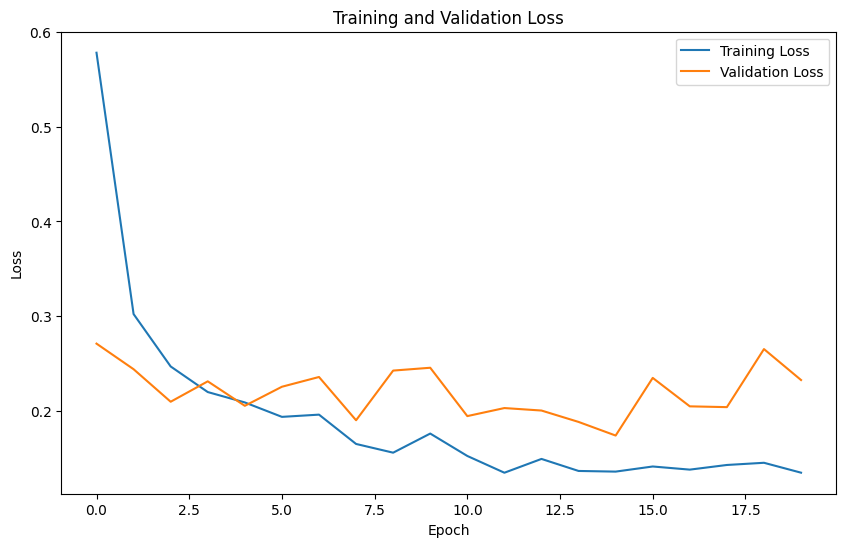

In [33]:
import matplotlib.pyplot as plt

# Assuming 'history' object is available from the model training cell (e.g., 7498030b)

if 'history' in globals() and history is not None:
    # Get the loss and validation loss from the history object
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(loss))

    # Plot training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
else:
    print("Error: 'history' object not found. Please ensure the model training cell was run successfully.")

Checking for model file: /content/best_model.keras
Loading the best model...
Model loaded successfully.

Manually collecting test image file paths and labels...
Expected class names from training generator: ['Damaged_highway', 'Non-damaged_building', 'Non-damaged_highway', 'damaged_buildings', 'debris']

Checking for expected class directories in the test set:
- Found directory for 'Damaged_highway'
- Found directory for 'Non-damaged_building'
- Found directory for 'Non-damaged_highway'
- Found directory for 'damaged_buildings'
- Found directory for 'debris'

Created DataFrame for test set with 600 images.

Setting up test data generator using flow_from_dataframe...
Found 600 validated image filenames belonging to 5 classes.
Test generator re-created using flow_from_dataframe.
Forcing test generator class indices to match training generator...
Class indices updated.
Number of true labels: 600
Making predictions on the test dataset...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 341ms/step
Predictions made.
Number of predicted labels: 600

Confusion Matrix:


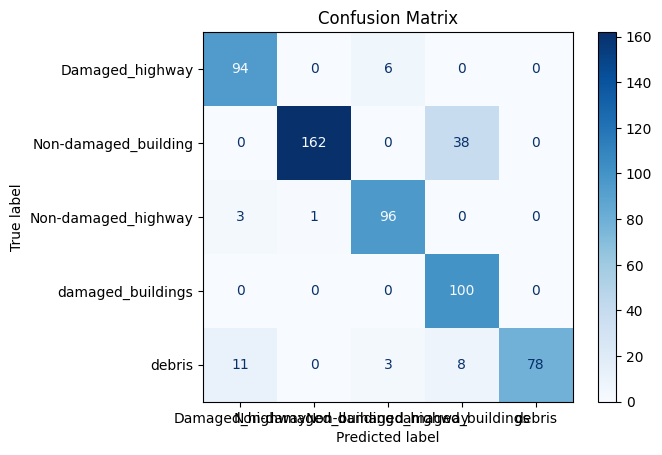

In [22]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import tensorflow as tf # Import tensorflow to load the model
import os # Import os to check for file existence
import pandas as pd # Import pandas for DataFrame
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Import ImageDataGenerator

# Define the model path
model_filepath = 'best_model.keras'

# Load the best performing model
best_model_loaded = None # Initialize to None
print(f"Checking for model file: {os.path.abspath(model_filepath)}")

if not os.path.exists(model_filepath):
    print(f"Error: Model file '{model_filepath}' not found. Cannot generate confusion matrix without the trained model.")
    print("Please ensure the model definition and training steps were executed successfully to save 'best_model.keras'.")
    exit() # Exit if the model file is not found

# Now attempt to load the model
print("Loading the best model...")
best_model_loaded = tf.keras.models.load_model(model_filepath)
print("Model loaded successfully.")

# --- Manually create a DataFrame for the test set ---
print("\nManually collecting test image file paths and labels...")
test_dir = 'dataset_extracted/test' # Assuming this path is correct

# Check if the test directory exists
if not os.path.isdir(test_dir):
    print(f"Error: Test directory '{test_dir}' not found.")
    exit()

# Get the list of expected class names from the training generator
# Assuming train_generator is available from previous cells (e.g., tNLZ9EvhDuoN or 12d19200)
if 'train_generator' not in globals() or not hasattr(train_generator, 'class_indices'):
    print("Error: train_generator or its class_indices not found. Cannot determine expected class names.")
    exit()

expected_class_names = list(train_generator.class_indices.keys())
print(f"Expected class names from training generator: {expected_class_names}")

# Check for the presence of expected class directories in the test set
print("\nChecking for expected class directories in the test set:")
found_class_dirs = []
missing_class_dirs = []
for class_name in expected_class_names:
    class_path = os.path.join(test_dir, class_name)
    if os.path.isdir(class_path):
        print(f"- Found directory for '{class_name}'")
        found_class_dirs.append(class_name)
    else:
        print(f"- Missing directory for '{class_name}'")
        missing_class_dirs.append(class_name)

if missing_class_dirs:
    print("\nError: The following expected class directories were NOT found in the test set. Please ensure the test directory structure matches the training classes exactly before proceeding.")
    print(f"Missing directories: {missing_class_dirs}")
    # Decide how to proceed: exit or continue with partial data
    # For generating a complete confusion matrix, it's better to exit and inform the user
    exit()


image_filepaths = []
image_labels = []

# Iterate through the found (expected) class directories in the test set
for class_name in found_class_dirs:
    class_dir = os.path.join(test_dir, class_name)
    # List image files in the class directory
    for filename in os.listdir(class_dir):
        filepath = os.path.join(class_dir, filename)
        # Add basic image file extension check
        if os.path.isfile(filepath) and filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_filepaths.append(filepath)
            image_labels.append(class_name)


if not image_filepaths:
    print("\nError: No image files found in the expected test directories even after checking for directories.")
    exit()

# Create a DataFrame
test_df = pd.DataFrame({'filepaths': image_filepaths, 'labels': image_labels})
print(f"\nCreated DataFrame for test set with {len(test_df)} images.")
# --- End of manually creating DataFrame ---

# --- Set up test generator using flow_from_dataframe ---
print("\nSetting up test data generator using flow_from_dataframe...")
# Assuming IMG_HEIGHT, IMG_WIDTH, BATCH_SIZE are defined from previous cells
if 'IMG_HEIGHT' not in globals() or 'IMG_WIDTH' not in globals() or 'BATCH_SIZE' not in globals():
     print("Error: Image dimensions or batch size not defined. Please ensure previous cells were run.")
     exit()

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False # Typically set to False for test data to maintain order
    # classes argument is not needed here as labels are provided in the DataFrame
)
print("Test generator re-created using flow_from_dataframe.")

# --- Ensure test generator class indices match training generator ---
# This step is still useful to explicitly set the internal mapping for consistency
if 'train_generator' in globals() and hasattr(train_generator, 'class_indices'):
    print("Forcing test generator class indices to match training generator...")
    test_generator.class_indices = train_generator.class_indices
    # Set class_names for confusion matrix display based on the consistent mapping
    class_names = list(train_generator.class_indices.keys())
    print("Class indices updated.")
else:
     print("Error: train_generator or its class_indices not found. Cannot ensure consistent class mapping for confusion matrix labels.")
     # Fallback - will likely lead to incorrect confusion matrix labels if class order is wrong
     if hasattr(test_generator, 'class_indices'):
         class_names = list(test_generator.class_indices.keys())
         print("Warning: Using test generator class indices (may not match training).")
     else:
         print("Error: test_generator.class_indices not found. Cannot generate confusion matrix with meaningful labels.")
         exit() # Exit if class names cannot be determined
# --- End of ensuring consistent class indices ---


# 1. Get true labels from the test generator
# The test_generator is set to shuffle=False, so the order of filepaths corresponds to the order of predictions.
# true_labels should now be correctly mapped due to flow_from_dataframe and class_indices enforcement
true_labels = test_generator.classes
print(f"Number of true labels: {len(true_labels)}")

# 2. Get model predictions for the test dataset
print("Making predictions on the test dataset...")
predictions = best_model_loaded.predict(test_generator)
print("Predictions made.")

# 3. Convert predictions from probabilities to class indices
predicted_labels = np.argmax(predictions, axis=1)
print(f"Number of predicted labels: {len(predicted_labels)}")


# 4. Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# 5. Display the confusion matrix
print("\nConfusion Matrix:")
# Use the class_names variable determined in the 'Ensure consistent class indices' block
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [35]:
from sklearn.metrics import classification_report

# Assuming true_labels and predicted_labels are available from the confusion matrix cell (e.g., 9IXkHwseyPMX)
# and class_names is available for display labels.

if 'true_labels' in globals() and 'predicted_labels' in globals() and 'class_names' in globals():
    print("Generating Classification Report...")
    report = classification_report(true_labels, predicted_labels, target_names=class_names)
    print(report)
else:
    print("Error: true_labels, predicted_labels, or class_names not found. Please ensure the confusion matrix cell was run successfully.")

Generating Classification Report...
                      precision    recall  f1-score   support

     Damaged_highway       0.87      0.94      0.90       100
Non-damaged_building       0.99      0.81      0.89       200
 Non-damaged_highway       0.91      0.96      0.94       100
   damaged_buildings       0.68      1.00      0.81       100
              debris       1.00      0.78      0.88       100

            accuracy                           0.88       600
           macro avg       0.89      0.90      0.88       600
        weighted avg       0.91      0.88      0.89       600



In [18]:
import numpy as np

In [20]:
from sklearn.metrics import confusion_matrix

In [21]:
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

cm = confusion_matrix(test_generator.classes, y_pred)
print(cm)

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step
[[ 92   0   6   2   0]
 [  0 173   0  27   0]
 [  4   1  94   1   0]
 [  0   0   0 100   0]
 [  8   0   1   9  82]]


In [23]:
import tensorflow as tf
import os

# Define the model path
model_filepath = 'best_model.keras'

# 1. Load the best performing model
print("Loading the best model...")
best_model = tf.keras.models.load_model(model_filepath)
print("Model loaded successfully.")

# 2. Evaluate the loaded model on the test_generator
print("\nEvaluating the model on the test dataset...")
eval_results = best_model.evaluate(test_generator)

# 3. Print the test loss and test accuracy
print(f"\nTest Loss: {eval_results[0]:.4f}")
print(f"Test Accuracy: {eval_results[1]:.4f}")

Loading the best model...
Model loaded successfully.

Evaluating the model on the test dataset...
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 250ms/step - accuracy: 0.8820 - loss: 0.3306

Test Loss: 0.3498
Test Accuracy: 0.8833


Using sample image from test set: dataset_extracted/test/Damaged_highway/3 (345).jpg
Image loaded successfully from dataset_extracted/test/Damaged_highway/3 (345).jpg
Making prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
Prediction made.

Predicted Class: Damaged_highway
Prediction Confidence: 0.9960

Prediction meets confidence threshold (0.90). Displaying result:


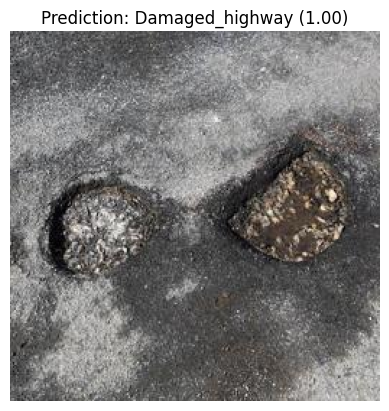

In [24]:
import numpy as np
from tensorflow.keras.preprocessing import image
from PIL import Image
import matplotlib.pyplot as plt
import os

# Re-using variables from previous steps
# best_model is assumed to be loaded from cell 93e189e1
# IMG_HEIGHT, IMG_WIDTH are assumed to be defined from cell 12d19200 or similar

# 1. Load a sample image for prediction
# We need to find a sample image file path. Let's take one from the test set.
# Assuming test_dir and test_generator are available from previous cells.
if 'test_generator' in globals() and test_generator.filepaths:
    sample_image_path = test_generator.filepaths[0]
    print(f"Using sample image from test set: {sample_image_path}")
else:
    print("test_generator or its filepaths not found. Cannot load a sample image automatically.")
    # Fallback: Manually specify a path if the above fails.
    # You might need to adjust this path based on your extracted dataset structure.
    # sample_image_path = 'dataset_extracted/test/some_class/some_image.jpeg'
    # if not os.path.exists(sample_image_path):
    #    print(f"Manual sample image path '{sample_image_path}' not found.")
    #    exit() # Exit if no image can be loaded

# Load the image
try:
    img = Image.open(sample_image_path)
    print(f"Image loaded successfully from {sample_image_path}")
except Exception as e:
    print(f"Error loading image: {e}")
    exit()


# 2. Preprocess the image
img_array = image.img_to_array(img.resize((IMG_WIDTH, IMG_HEIGHT)))
img_array = np.expand_dims(img_array, axis=0) # Add batch dimension
img_array /= 255.0 # Rescale pixel values

# 3. Make a prediction
print("Making prediction...")
predictions = best_model.predict(img_array)
print("Prediction made.")

# 4. Get the confidence scores and predicted class
confidence_scores = predictions[0]
predicted_class_index = np.argmax(confidence_scores)
predicted_confidence = confidence_scores[predicted_class_index]

# Get class labels from the generator
# Assuming train_generator is available and has class_indices
if 'train_generator' in globals():
    class_indices = train_generator.class_indices
    # Invert the dictionary to get class labels by index
    class_labels = {v: k for k, v in class_indices.items()}
    predicted_class_label = class_labels[predicted_class_index]
else:
    print("train_generator not found. Cannot retrieve class labels.")
    predicted_class_label = f"Class Index {predicted_class_index}" # Use index if labels not available


# 5. & 6. Display the prediction if confidence is >= 90% (0.90)
confidence_threshold = 0.90

print(f"\nPredicted Class: {predicted_class_label}")
print(f"Prediction Confidence: {predicted_confidence:.4f}")

if predicted_confidence >= confidence_threshold:
    print(f"\nPrediction meets confidence threshold ({confidence_threshold:.2f}). Displaying result:")
    plt.imshow(img)
    plt.title(f"Prediction: {predicted_class_label} ({predicted_confidence:.2f})")
    plt.axis('off')
    plt.show()
else:
    print(f"\nPrediction confidence ({predicted_confidence:.2f}) is below the threshold ({confidence_threshold:.2f}). Prediction not displayed.")